In [96]:
# loading the data (making )

import sklearn
from sklearn.datasets import make_circles

In [97]:
n_samples = 1000
X,y = make_circles(
    n_samples, noise = 0.03,
    random_state=42
)

In [98]:
import pandas as pd

circles = pd.DataFrame({"X1":X[:,0],
                        "X2": X[:,1],
                        "label":y
                        },
                       )

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


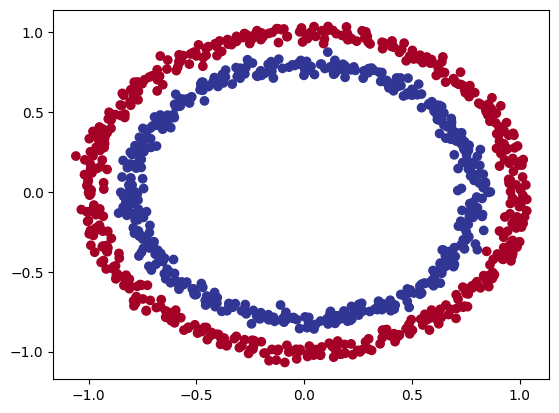

In [99]:
# data visualization
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0], y=X[:,1],c = y, cmap=plt.cm.RdYlBu)
plt.show()

In [100]:
# convertion the data into tensors
# X.shape, y.shape
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

In [101]:
# passing the data into tensors
import torch
torch.__version__

'2.2.1+cu121'

In [102]:
X = torch.from_numpy(X).type(torch.float32)

In [103]:
y = torch.from_numpy(y).type(torch.float32)

In [104]:
# splitting data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state = 42

                                                    )

In [105]:
len(X_train), len(X_test)

(800, 200)

In [106]:
# building a model for the classification

device ="cuda" if torch.cuda.is_available() else "cpu"
from torch import nn

In [107]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [108]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2,5)
    self.layer_2 = nn.Linear(5,1)
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # chain of the neural network

# instantiate an instance if the model class
model_0 = CircleModelV0().to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [109]:
# simple model replication with nn

model_0 = nn.Sequential(
    nn.Linear(2,5),
    nn.Linear(5,1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [110]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [111]:
untrained_preds = model_0(X_test.to(device))

print(f'length of predictions: {len(X_test)}, Shape: {X_test.shape}')
print(f'\n First 10 predictions:\n{untrained_preds[:10]}')
# print(f'')


length of predictions: 200, Shape: torch.Size([200, 2])

 First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], grad_fn=<SliceBackward0>)


In [112]:
# picking loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)


In [113]:
def accuaracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [114]:
# training the mode

epochs = 100
y_logits = model_0(X_test.to(device)[:5])

y_logits



tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], grad_fn=<AddmmBackward0>)

In [115]:
# using the sigmoid function on our logits

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], grad_fn=<SigmoidBackward0>)

In [116]:
print(torch.round(y_pred_probs))

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)


In [117]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
 model_0.train()
 y_logits  = model_0(X_train).squeeze()
 y_pred = torch.round(torch.sigmoid(y_logits))
 loss = loss_fn(y_logits,y_train)
 acc = accuaracy_fn(y_train, y_pred)
 optimizer.zero_grad()
 loss.backward()

 optimizer.step()

 model_0.eval()

 with torch.inference_mode():
  test_logits = model_0(X_test).squeeze()
  test_pred = torch.round(torch.sigmoid(test_logits))

  test_loss = loss_fn(test_logits,y_test)
  test_acc = accuaracy_fn(y_test, test_pred)

  if epoch %10 ==0:
    print(f"Epoch: {epoch}| Loss: {loss:.5f} Accuracy: {acc:.2f}%| Test Loss: {test_loss} | Test acc: {test_acc:.2f}%")






Epoch: 0| Loss: 0.69796 Accuracy: 51.88%| Test Loss: 0.6945955753326416 | Test acc: 57.50%
Epoch: 10| Loss: 0.69768 Accuracy: 52.00%| Test Loss: 0.6943801045417786 | Test acc: 58.00%
Epoch: 20| Loss: 0.69742 Accuracy: 52.00%| Test Loss: 0.6941847205162048 | Test acc: 57.50%
Epoch: 30| Loss: 0.69717 Accuracy: 52.00%| Test Loss: 0.6940073370933533 | Test acc: 56.50%
Epoch: 40| Loss: 0.69695 Accuracy: 51.62%| Test Loss: 0.6938462853431702 | Test acc: 56.50%
Epoch: 50| Loss: 0.69675 Accuracy: 51.38%| Test Loss: 0.6937000155448914 | Test acc: 56.00%
Epoch: 60| Loss: 0.69656 Accuracy: 51.38%| Test Loss: 0.6935670971870422 | Test acc: 56.00%
Epoch: 70| Loss: 0.69638 Accuracy: 51.38%| Test Loss: 0.6934463381767273 | Test acc: 56.50%
Epoch: 80| Loss: 0.69621 Accuracy: 51.25%| Test Loss: 0.6933364868164062 | Test acc: 56.50%
Epoch: 90| Loss: 0.69606 Accuracy: 51.38%| Test Loss: 0.6932365298271179 | Test acc: 55.00%


In [118]:
# making the model more visual
# from the matrics it seems the model is not learning
# makr predictions and make them visual

import requests
from pathlib import Path

# downloading pytorch helper funrtions to colab if not already available

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open("helper_functions.py", 'wb') as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [119]:
from helper_functions import plot_predictions, plot_decision_boundary

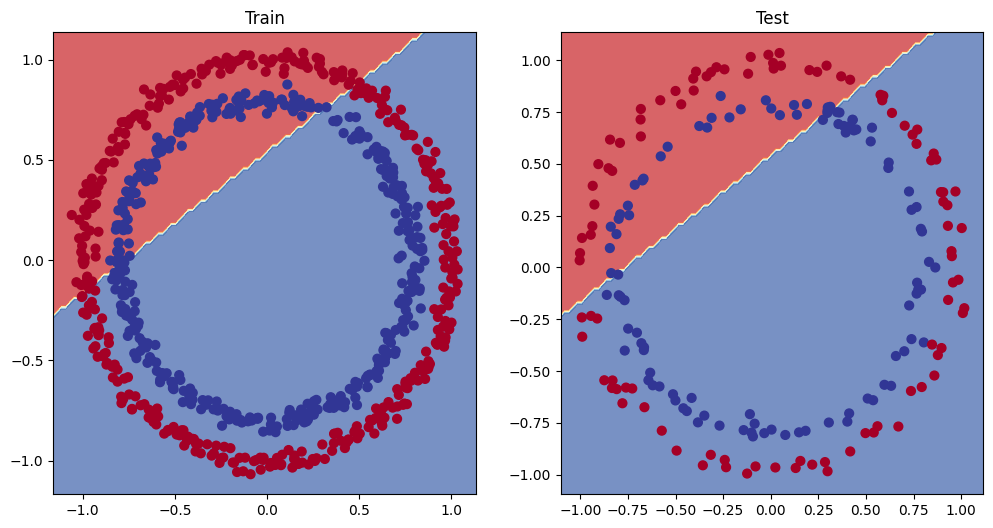

In [120]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)

plt.title("Test")

plot_decision_boundary(model_0, X_test, y_test)


In [121]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2,10)
    self.layer_2 = nn.Linear(10,10)
    self.layer_3 = nn.Linear(10,1)
  def forward(self, x):
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    return z
# # instantiate an instance if the model class
# model_0 = CircleModelV0().to(device)

# model_0
model_1 = CircleModelV2()

model_1


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [122]:
# creating a loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)



In [123]:
torch.cuda.manual_seed(42)
epochs = 1001

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # accuracy calculation
  loss = loss_fn(y_logits, y_train)
  acc = accuaracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
     test_logits = model_0(X_test).squeeze()
     test_pred = torch.round(torch.sigmoid(test_logits))

     test_loss = loss_fn(test_logits,y_test)
     test_acc = accuaracy_fn(y_test, test_pred)

     if epoch %100 ==0:
       print(f"Epoch: {epoch}| Loss: {loss:.5f} Accuracy: {acc:.2f}%| Test Loss: {test_loss} | Test acc: {test_acc:.2f}%")


Epoch: 0| Loss: 0.69396 Accuracy: 50.88%| Test Loss: 0.6931544542312622 | Test acc: 54.50%
Epoch: 100| Loss: 0.69305 Accuracy: 50.38%| Test Loss: 0.6931544542312622 | Test acc: 54.50%
Epoch: 200| Loss: 0.69299 Accuracy: 51.12%| Test Loss: 0.6931544542312622 | Test acc: 54.50%
Epoch: 300| Loss: 0.69298 Accuracy: 51.62%| Test Loss: 0.6931544542312622 | Test acc: 54.50%
Epoch: 400| Loss: 0.69298 Accuracy: 51.12%| Test Loss: 0.6931544542312622 | Test acc: 54.50%
Epoch: 500| Loss: 0.69298 Accuracy: 51.00%| Test Loss: 0.6931544542312622 | Test acc: 54.50%
Epoch: 600| Loss: 0.69298 Accuracy: 51.00%| Test Loss: 0.6931544542312622 | Test acc: 54.50%
Epoch: 700| Loss: 0.69298 Accuracy: 51.00%| Test Loss: 0.6931544542312622 | Test acc: 54.50%
Epoch: 800| Loss: 0.69298 Accuracy: 51.00%| Test Loss: 0.6931544542312622 | Test acc: 54.50%
Epoch: 900| Loss: 0.69298 Accuracy: 51.00%| Test Loss: 0.6931544542312622 | Test acc: 54.50%
Epoch: 1000| Loss: 0.69298 Accuracy: 51.00%| Test Loss: 0.69315445423126

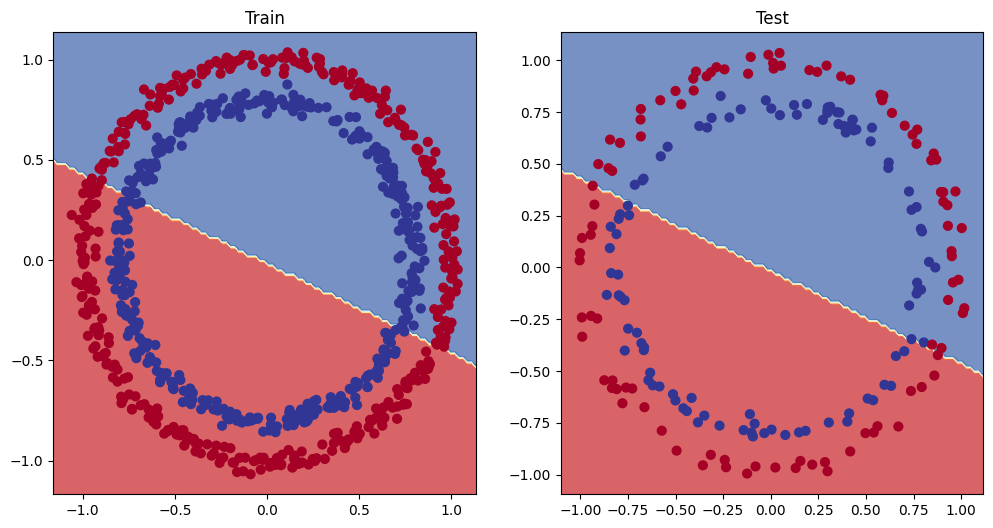

In [124]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)

plt.title("Test")

plot_decision_boundary(model_1, X_test, y_test)


In [125]:
# tryinh yo perform some model analysis

weight = 0.7
bias = 0.3
start = 0
end = 1
step  = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias

# checking the data

print(len(X_regression))
X_regression[:5]

100


tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]])

In [126]:
train_split = int(0.8* len(X_regression))
X_train_regression,y_train_regression =X_regression[:train_split], y_regression[:train_split]

X_test_regression,y_test_regression =X_regression[train_split:], y_regression[train_split:]

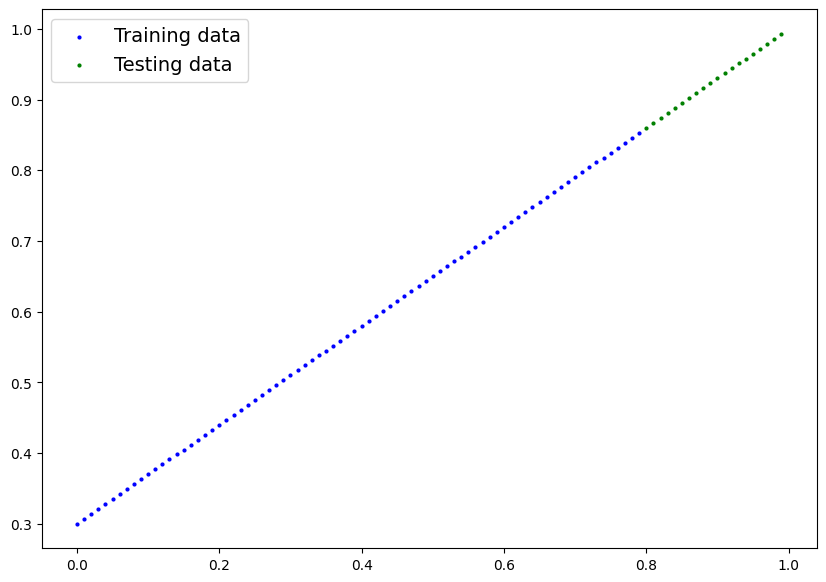

In [127]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression,test_data=X_test_regression, test_labels=y_test_regression)

In [128]:
# adjusting model 1 to fit straight line data
model_2 = nn.Sequential(
    nn.Linear(1,10),
    nn.Linear(10,10),
    nn.Linear(10,1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [129]:
# creating a loss
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.01)


In [130]:
# model_training

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression, X_test_regression, y_test_regression = X_train_regression.to(device), y_train_regression.to(device), X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_predictions = model_2(X_test_regression)
    test_loss = loss_fn(test_predictions, y_test_regression)
    if epoch %100==0:
      print(f"Epoch: {epoch} <-> Train_Loss : {loss} <-> Test_Loss : {test_loss}")
# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.title("Train")
# plot_decision_boundary(model_2, X_train_regression, y_train_regression)


Epoch: 0 <-> Train_Loss : 0.5789582133293152 <-> Test_Loss : 0.8227251768112183
Epoch: 100 <-> Train_Loss : 0.03496142849326134 <-> Test_Loss : 0.001556271337904036
Epoch: 200 <-> Train_Loss : 0.03267959877848625 <-> Test_Loss : 0.0033015250228345394
Epoch: 300 <-> Train_Loss : 0.02942253090441227 <-> Test_Loss : 0.004460394382476807
Epoch: 400 <-> Train_Loss : 0.027310658246278763 <-> Test_Loss : 0.0056967050768435
Epoch: 500 <-> Train_Loss : 0.026715081185102463 <-> Test_Loss : 0.005340182688087225
Epoch: 600 <-> Train_Loss : 0.026268724352121353 <-> Test_Loss : 0.00510598998516798
Epoch: 700 <-> Train_Loss : 0.025940800085663795 <-> Test_Loss : 0.004957902245223522
Epoch: 800 <-> Train_Loss : 0.024818608537316322 <-> Test_Loss : 0.003935986664146185
Epoch: 900 <-> Train_Loss : 0.023327991366386414 <-> Test_Loss : 0.004619506187736988


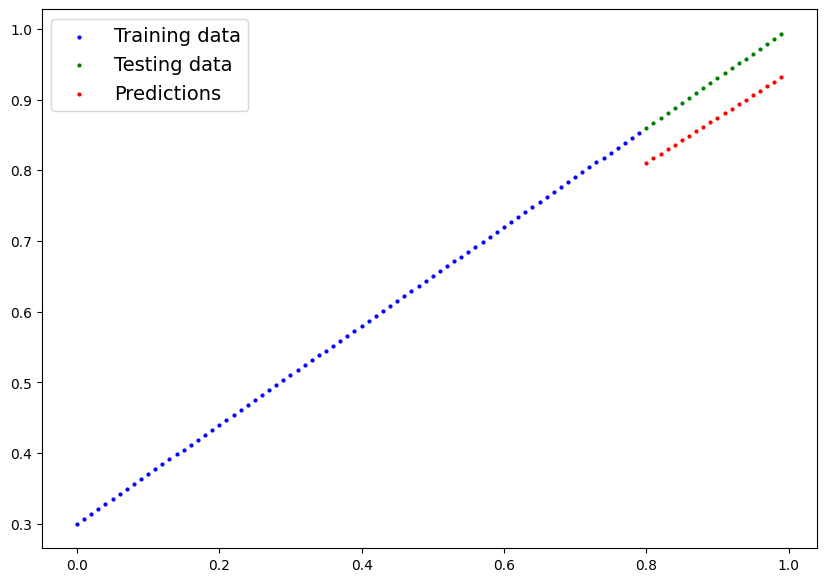

In [131]:
# performing a prediction and using that to perform the plotting operation
model_2.eval()
with torch.inference_mode():
  predictions = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression, train_labels=y_train_regression,test_data=X_test_regression, test_labels=y_test_regression,predictions=predictions)


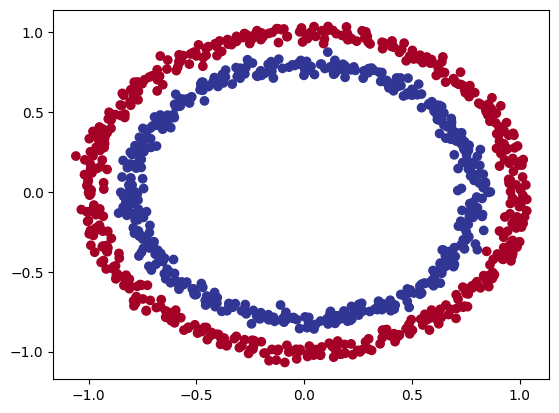

In [132]:
# recreating the non-linear data that was intially created just for practice purpose
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X , y = make_circles(n_samples,
                     noise = 0.03,
                     random_state=42
                     )

plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu)


In [133]:
# create train and test split of the data
# convert X and y to tensors then split
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state=42)

len(X_train), len(X_test)

(800, 200)

In [134]:
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2,10)
    self.layer_2 = nn.Linear(10,10)
    self.layer_3 = nn.Linear(10,1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [135]:
model_3 = CircleModelV3()
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [136]:
# writing the training loop
# choosing the optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_3.parameters(), lr = 0.1)

In [137]:
# building the whole data training loop
torch.manual_seed(42)
torch.cuda.manual_seed
epochs = 1001

model_3.to(device)
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  # getting the y_logits from the model
  y_logits = model_3(X_train).squeeze()
  predictions = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuaracy_fn(y_train, predictions)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()

  with torch.inference_mode():
    test_logits  = model_3(X_test).squeeze()
    test_predictions = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    accuracy = accuaracy_fn(y_test, test_predictions)
    if epoch % 100 == 0:
      print(f"Epoch:{epoch} | Train_Loss:{loss:.5f} |Train_Acc:{acc}%| Test_loss:{test_loss:.5f} | Test_Acc:{accuracy}")




Epoch:0 | Train_Loss:0.69295 |Train_Acc:50.0%| Test_loss:0.69319 | Test_Acc:50.0
Epoch:100 | Train_Loss:0.69115 |Train_Acc:52.87500000000001%| Test_loss:0.69102 | Test_Acc:52.5
Epoch:200 | Train_Loss:0.68977 |Train_Acc:53.37499999999999%| Test_loss:0.68940 | Test_Acc:55.00000000000001
Epoch:300 | Train_Loss:0.68795 |Train_Acc:53.0%| Test_loss:0.68723 | Test_Acc:56.00000000000001
Epoch:400 | Train_Loss:0.68517 |Train_Acc:52.75%| Test_loss:0.68411 | Test_Acc:56.49999999999999
Epoch:500 | Train_Loss:0.68102 |Train_Acc:52.75%| Test_loss:0.67941 | Test_Acc:56.49999999999999
Epoch:600 | Train_Loss:0.67515 |Train_Acc:54.50000000000001%| Test_loss:0.67285 | Test_Acc:56.00000000000001
Epoch:700 | Train_Loss:0.66659 |Train_Acc:58.375%| Test_loss:0.66322 | Test_Acc:59.0
Epoch:800 | Train_Loss:0.65160 |Train_Acc:64.0%| Test_loss:0.64757 | Test_Acc:67.5
Epoch:900 | Train_Loss:0.62362 |Train_Acc:74.0%| Test_loss:0.62145 | Test_Acc:79.0
Epoch:1000 | Train_Loss:0.56818 |Train_Acc:87.75%| Test_loss:0.5

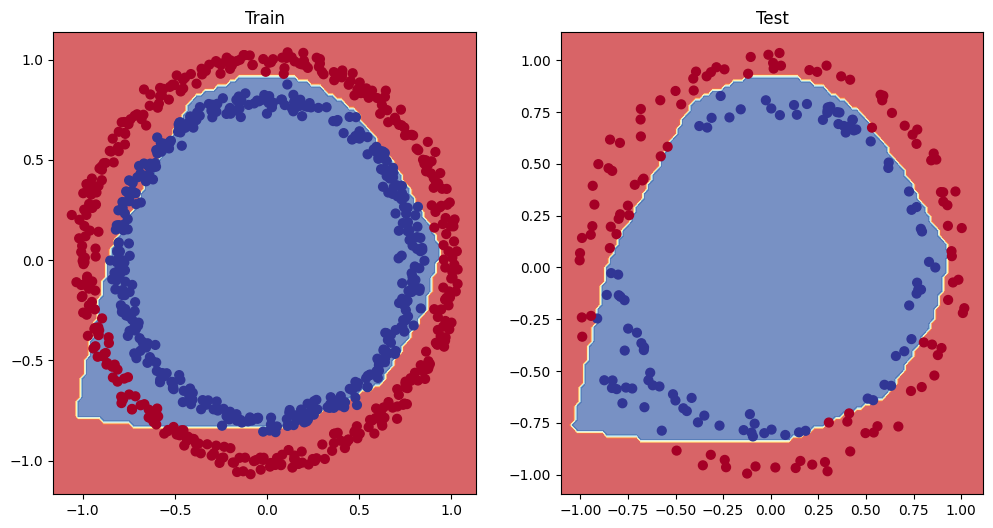

In [138]:
model_3.eval()
with torch.inference_mode():
  y_pred = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1,2,2)

plt.title("Test")

plot_decision_boundary(model_3, X_test, y_pred)


In [139]:
# replication non-linear activations
A = torch.arange(-10,10,1)
A.type(torch.float)



tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

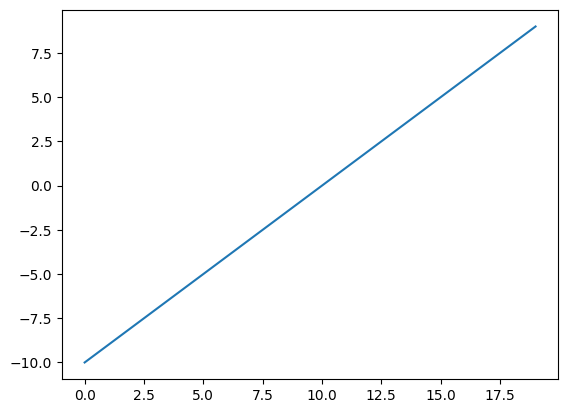

In [140]:
# data_visualization
plt.plot(A)

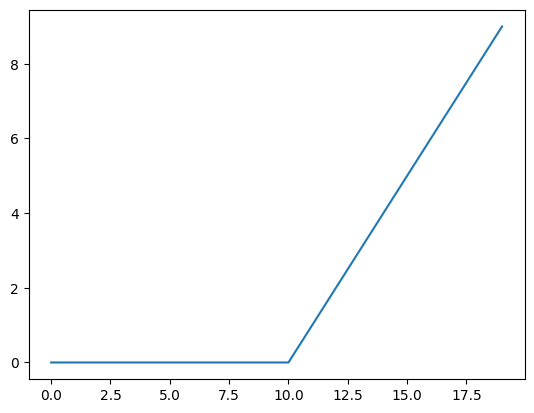

In [141]:
plt.plot(torch.relu(A))

In [142]:
# recreating RELU

def relu(x:torch.Tensor)->torch.tensor:
  return torch.maximum(torch.tensor(0),x)

A_T = relu(A)
A_T

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

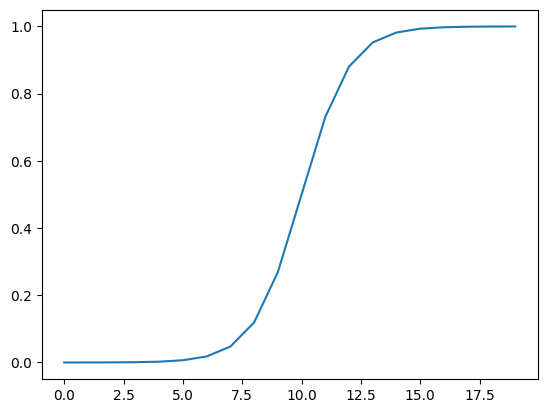

In [143]:
def sigmoid(x:torch.Tensor)->torch.Tensor:
  return 1/(1+torch.exp(-x))
A_Sig = sigmoid(A)
plt.plot(A_Sig)

### Multiclass Classification problem

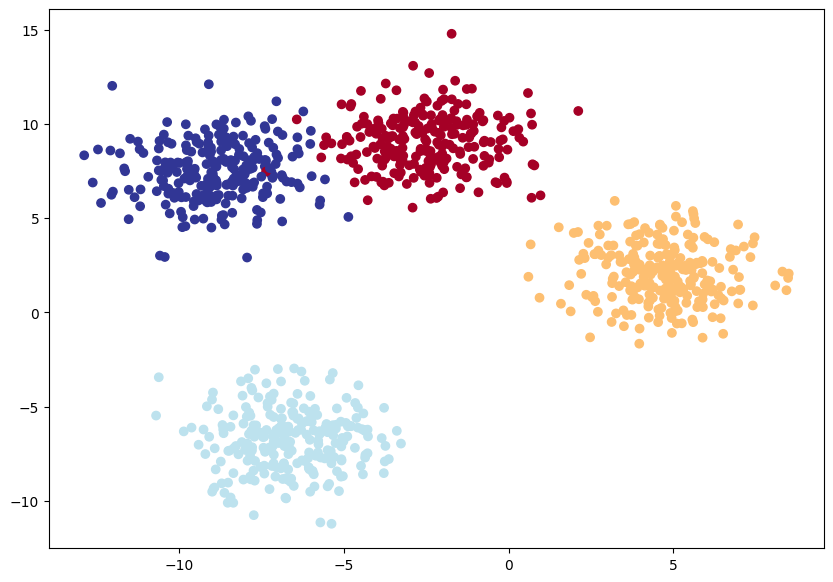

In [144]:
# importing dependencies

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES  = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


# creating data

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features = NUM_FEATURES,
                            centers =NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED
                            )

X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)
# splitting into train and test samples

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# Visualization of the data

plt.figure(figsize = (10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c = y_blob, cmap=plt.cm.RdYlBu)

In [145]:
# creating the multiclass classification
# creating device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [157]:
# building a multiclass classification

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi class classification model

    Args:
      input_features(int): Number of input features to the model
      output_features(int): Number of outputs features(number of output classes)
      hidden_units (int): number of units between layers default 8

    """

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features)
    )

  def forward(self, x:torch.Tensor)->torch.Tensor:
    return self.linear_layer_stack(x)
# create instance of blob model
model_4 = BlobModel(2,4,8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [153]:
# creating the loss function and the training loop
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_4.parameters(), lr=0.1)

In [154]:
y_blob_train.dtype

torch.int64

In [155]:
# creating the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# moving the data on to the device

X_blob_train, X_blob_test, y_blob_train, y_blob_test  = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)
# creating a training, testing loop

epochs = 100

for epoch in range(epochs):
  model_4.train()
  y_blob_logits =model_4(X_blob_train)
  y_blob_probs = torch.softmax(y_blob_logits,dim=1)
  y_blob_pred =  y_blob_probs.argmax(dim=1)

  acc = accuaracy_fn(y_blob_train, y_blob_pred)

  loss = loss_fn(y_blob_logits, y_blob_train)

  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  # performing the operation for the evauation
  model_4.eval()
  with torch.inference_mode():
    y_blob_test_logits = model_4(X_blob_test)
    y_blob_test_preds = torch.softmax(y_blob_test_logits, dim=1).argmax(dim=1)
    test_acc = accuaracy_fn(y_blob_test, y_blob_test_preds)
    test_loss = loss_fn(y_blob_test_logits,y_blob_test )
    if epoch %10 ==0:
      print(f'Epoch:{epoch} <-> Train Loss:{loss:.5f} <-> Train Accuracy:{acc:.2f}% Test Loss:{test_loss:.3f} Test Accuracy:{test_acc:.2f}%')



Epoch:0 <-> Train Loss:1.04324 <-> Train Accuracy:65.50% Test Loss:0.579 Test Accuracy:95.50%
Epoch:10 <-> Train Loss:0.14398 <-> Train Accuracy:99.12% Test Loss:0.130 Test Accuracy:99.00%
Epoch:20 <-> Train Loss:0.08062 <-> Train Accuracy:99.12% Test Loss:0.072 Test Accuracy:99.50%
Epoch:30 <-> Train Loss:0.05924 <-> Train Accuracy:99.12% Test Loss:0.051 Test Accuracy:99.50%
Epoch:40 <-> Train Loss:0.04892 <-> Train Accuracy:99.00% Test Loss:0.041 Test Accuracy:99.50%
Epoch:50 <-> Train Loss:0.04295 <-> Train Accuracy:99.00% Test Loss:0.035 Test Accuracy:99.50%
Epoch:60 <-> Train Loss:0.03910 <-> Train Accuracy:99.00% Test Loss:0.031 Test Accuracy:99.50%
Epoch:70 <-> Train Loss:0.03643 <-> Train Accuracy:99.00% Test Loss:0.028 Test Accuracy:99.50%
Epoch:80 <-> Train Loss:0.03448 <-> Train Accuracy:99.00% Test Loss:0.026 Test Accuracy:99.50%
Epoch:90 <-> Train Loss:0.03300 <-> Train Accuracy:99.12% Test Loss:0.024 Test Accuracy:99.50%


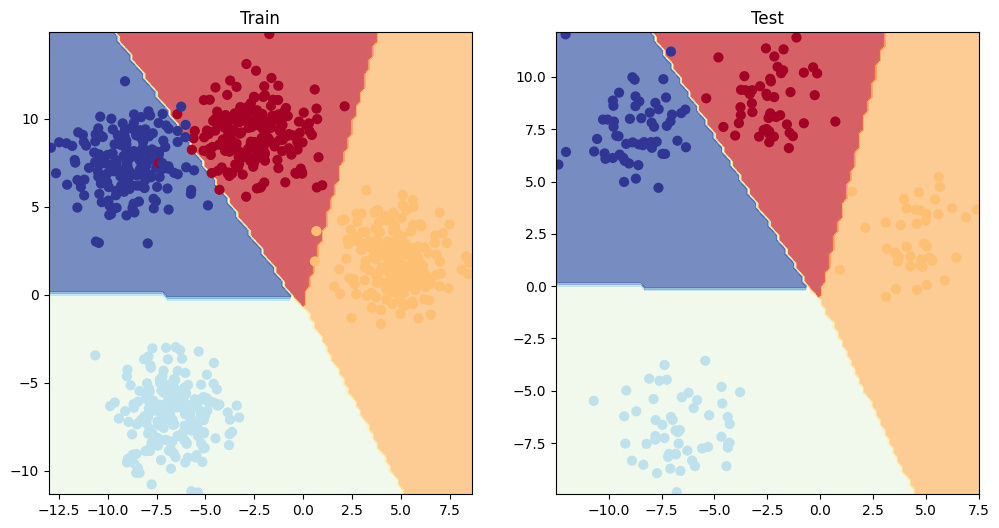

In [156]:
# Plotting the decision boundary
model_4.eval()
with torch.inference_mode():
  y_pred = torch.round(torch.sigmoid(model_4(X_blob_test))).squeeze()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1,2,2)

plt.title("Test")

plot_decision_boundary(model_4, X_blob_test, y_blob_test)


In [158]:
# a few more classification metrics
!pip install torchmetrics
from torchmetrics import Accuracy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many